load library and dataset

In [ ]:
import pandas as pd
import numpy as np
import glob
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 1.8 MB/s eta 0:00:00


### Preprocessing Step by Step Showing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230301.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230302.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230303.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230304.csv', engine='python')

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,FNS_TIME_CD,IN_FORN_DIV_NM,FORN_CITIZ_NM,MOVE_PURPOSE,MOVE_DIST,MOVE_TIME,CNT,ETL_YMD
0,11110515.0,11110515,0,0,단기외국인,ㆍ값없음,3,350.0,0.946667,3.50,20230302
1,11110515.0,11110515,0,0,내국인,ㆍ값없음,3,801.6,2.671667,2.74,20230302
2,11110515.0,11110515,0,0,내국인,한국,3,180.3,1.350000,4.13,20230302
3,11110515.0,11110540,0,0,내국인,ㆍ값없음,7,651.9,2.133333,2.48,20230302
4,11110515.0,11110550,0,0,단기외국인,ㆍ값없음,3,2220.9,7.146667,3.50,20230302


In [ ]:
# Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]

In [ ]:
df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)

In [ ]:
df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

In [ ]:
# df['O_ADMDONG_CD'].value_counts(dropna = False).to_frame().to_excel("/content/drive/MyDrive/FMC_Data/M-B_dong_202303/O_ADMDONG_CD_value_counts_0304_after_process2.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11113762 entries, 0 to 11113996
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   O_ADMDONG_CD    int64  
 1   D_ADMDONG_CD    int64  
 2   ST_TIME_CD      int64  
 3   FNS_TIME_CD     int64  
 4   IN_FORN_DIV_NM  object 
 5   FORN_CITIZ_NM   object 
 6   MOVE_PURPOSE    int64  
 7   MOVE_DIST       float64
 8   MOVE_TIME       float64
 9   CNT             float64
 10  ETL_YMD         int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 1017.5+ MB


1: Going to Work, 2 : Going to School, 3: Going back to home, 4: Shopping, 5: Sightseeing/Tourism, 6: Hospital, 7: Others

In [ ]:
# Add product MOVE_DIST & MOVE_TIME
# Calculate the new variable and add it as a new column
df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

In [ ]:
# Filter the purpose
df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
df_1 = df[df['MOVE_PURPOSE']==1]
df_3 = df[df['MOVE_PURPOSE'] == 3]

In [ ]:
# Aggregate the dataset
# Aggregating purpose 2,4,5,6,7 (all except going to work(1) and coming back to home(3)) trip
aggregated_df_24567 = df_24567.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

# Aggregating purpose 1 (going to work) trip
aggregated_df_1 = df_1.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

In [ ]:
# Merge the two aggregated DataFrames on ['O_ADMDONG_CD', 'D_ADMDONG_CD']
merged_df = pd.merge(aggregated_df_24567, aggregated_df_1, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], suffixes=('_24567', '_1'), how='left')

# Fill NaN values with 0 (in case there are no purpose 1 trips for some O-D pairs)
merged_df = merged_df.fillna(0)

In [ ]:
#@title Calculate the return trips after all non-work visits (RT-NonWork)
# Calculate the return trips after all non-work visits (RT-NonWork)
merged_df['RT-NonWork_CNT'] = merged_df['CNT_24567'] - merged_df['CNT_1']
merged_df['RT-NonWork_MOVE_DISTxCNT'] = merged_df['MOVE_DISTxCNT_24567'] - merged_df['MOVE_DISTxCNT_1']
merged_df['RT-NonWork_MOVE_TIMExCNT'] = merged_df['MOVE_TIMExCNT_24567'] - merged_df['MOVE_TIMExCNT_1']

In [ ]:
#@title Aggregating purpose 3 (coming back to home) trip
aggregated_df_3 = df_3.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

# Rename columns to add the _3 suffix
aggregated_df_3.rename(columns={
    'CNT': 'CNT_3',
    'MOVE_DISTxCNT': 'MOVE_DISTxCNT_3',
    'MOVE_TIMExCNT': 'MOVE_TIMExCNT_3'
}, inplace=True)

# Merge the aggregated_df_3 with the merged_df that contains RT-NonWork data
final_merged_df = pd.merge(merged_df, aggregated_df_3, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], how='left')

# Fill NaN values with 0 (in case there are no purpose 3 trips for some O-D pairs)
final_merged_df = final_merged_df.fillna(0)

# Calculate the going home after work trips (RT-Work)
final_merged_df['RT-Work_CNT'] = final_merged_df['CNT_3'] - final_merged_df['RT-NonWork_CNT']
final_merged_df['RT-Work_MOVE_DISTxCNT'] = final_merged_df['MOVE_DISTxCNT_3'] - final_merged_df['RT-NonWork_MOVE_DISTxCNT']
final_merged_df['RT-Work_MOVE_TIMExCNT'] = final_merged_df['MOVE_TIMExCNT_3'] - final_merged_df['RT-NonWork_MOVE_TIMExCNT']

# Select relevant columns for the final DataFrame
final_df = final_merged_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_24567', 'CNT_1', 'MOVE_DISTxCNT_24567', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_24567', 'MOVE_TIMExCNT_1', 'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT', 'CNT_3', 'MOVE_DISTxCNT_3', 'MOVE_TIMExCNT_3', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

# Reorder the columns in the final DataFrame
final_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'CNT_3', 'CNT_24567',
                     'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3', 'MOVE_DISTxCNT_24567',
                     'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567',
                     'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT',
                     'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

# add and work trip-related columns and non-work trip-related columns separately
count_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','CNT_1', 'CNT_3', 'CNT_24567', 'RT-NonWork_CNT', 'RT-Work_CNT']]
work_related_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_1', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

##### exporting file examples

In [ ]:
# # save the final DataFrame to a new CSV file
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230301.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230302.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230303.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230304.csv', index=False)

In [ ]:
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230301.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230302.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230303.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230304.csv', index=False)

In [ ]:
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230301.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230302.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230303.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230304.csv', index=False)

### Preprocessing code (Loop)

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{:02d}.csv"
output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"
count_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"
work_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Loop over the files
for day in range(5, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')

    # preprocessing steps
    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]
    df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

    # Add product MOVE_DIST & MOVE_TIME
    # Calculate the new variable and add it as a new column
    df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
    df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

    # Filter the purpose
    df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
    df_1 = df[df['MOVE_PURPOSE']==1]
    df_3 = df[df['MOVE_PURPOSE'] == 3]

    # Aggregate the dataset
    # Aggregating purpose 2,4,5,6,7 (all except going to work(1) and coming back to home(3)) trip
    aggregated_df_24567 = df_24567.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Aggregating purpose 1 (going to work) trip
    aggregated_df_1 = df_1.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Merge the two aggregated DataFrames on ['O_ADMDONG_CD', 'D_ADMDONG_CD']
    merged_df = pd.merge(aggregated_df_24567, aggregated_df_1, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], suffixes=('_24567', '_1'), how='left')

    # Fill NaN values with 0 (in case there are no purpose 1 trips for some O-D pairs)
    merged_df = merged_df.fillna(0)

    # Calculate the return trips after all non-work visits (RT-NonWork)
    merged_df['RT-NonWork_CNT'] = merged_df['CNT_24567'] - merged_df['CNT_1']
    merged_df['RT-NonWork_MOVE_DISTxCNT'] = merged_df['MOVE_DISTxCNT_24567'] - merged_df['MOVE_DISTxCNT_1']
    merged_df['RT-NonWork_MOVE_TIMExCNT'] = merged_df['MOVE_TIMExCNT_24567'] - merged_df['MOVE_TIMExCNT_1']

    # Aggregating purpose 3 (coming back to home) trip
    aggregated_df_3 = df_3.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Rename columns to add the _3 suffix
    aggregated_df_3.rename(columns={
        'CNT': 'CNT_3',
        'MOVE_DISTxCNT': 'MOVE_DISTxCNT_3',
        'MOVE_TIMExCNT': 'MOVE_TIMExCNT_3'
    }, inplace=True)

    # Merge the aggregated_df_3 with the merged_df that contains RT-NonWork data
    final_merged_df = pd.merge(merged_df, aggregated_df_3, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], how='left')

    # Fill NaN values with 0 (in case there are no purpose 3 trips for some O-D pairs)
    final_merged_df = final_merged_df.fillna(0)

    # Calculate the going home after work trips (RT-Work)
    final_merged_df['RT-Work_CNT'] = final_merged_df['CNT_3'] - final_merged_df['RT-NonWork_CNT']
    final_merged_df['RT-Work_MOVE_DISTxCNT'] = final_merged_df['MOVE_DISTxCNT_3'] - final_merged_df['RT-NonWork_MOVE_DISTxCNT']
    final_merged_df['RT-Work_MOVE_TIMExCNT'] = final_merged_df['MOVE_TIMExCNT_3'] - final_merged_df['RT-NonWork_MOVE_TIMExCNT']

    # Select relevant columns for the final DataFrame
    final_df = final_merged_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_24567', 'CNT_1', 'MOVE_DISTxCNT_24567', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_24567', 'MOVE_TIMExCNT_1', 'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT', 'CNT_3', 'MOVE_DISTxCNT_3', 'MOVE_TIMExCNT_3', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # Reorder the columns in the final DataFrame
    final_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'CNT_3', 'CNT_24567',
                        'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3', 'MOVE_DISTxCNT_24567',
                        'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567',
                        'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT',
                        'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # add and work trip-related columns and non-work trip-related columns separately
    count_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','CNT_1', 'CNT_3', 'CNT_24567', 'RT-NonWork_CNT', 'RT-Work_CNT']]
    work_related_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_1', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # Save the final DataFrames
    output_path = output_path_template.format(day)
    count_output_path = count_output_path_template.format(day)
    work_output_path = work_output_path_template.format(day)
    final_df.to_csv(output_path, index=False)
    count_df.to_csv(count_output_path, index=False)
    work_related_df.to_csv(work_output_path, index=False)

<ipython-input-113-0a1c952188c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-113-0a1c952188c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-113-0a1c952188c8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

### Concatenating Codes


#### load aggregated Num Dist Time data and combine those

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"

# Create a list to store all data frames
df_list = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')
    df_list.append(df)  # Add the current data frame to the list

In [ ]:
# Loop over the list and print the data type of 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
for i, df in enumerate(df_list, start=1):
    print(f"DataFrame df{i}:")
    print(f"O_ADMDONG_CD dtype: {df['O_ADMDONG_CD'].dtype}")
    print(f"D_ADMDONG_CD dtype: {df['D_ADMDONG_CD'].dtype}")
    print()

DataFrame df1:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df2:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df3:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df4:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df5:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df6:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df7:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df8:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df9:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df10:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df11:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df12:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df13:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df14:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df15:
O_ADMDONG_CD dtype: int64
D

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan = pd.concat(df_list, ignore_index=True)

In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['O_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['D_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df = big_df_noNan.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_DISTxCNT_3': 'sum',
    'MOVE_DISTxCNT_24567': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'MOVE_TIMExCNT_3': 'sum',
    'MOVE_TIMExCNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-NonWork_MOVE_DISTxCNT': 'sum',
    'RT-NonWork_MOVE_TIMExCNT': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df['Avg_DIST_1'] = aggregated_df['MOVE_DISTxCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_DIST_3'] = aggregated_df['MOVE_DISTxCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_DIST_24567'] = aggregated_df['MOVE_DISTxCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_DIST'] = aggregated_df['RT-NonWork_MOVE_DISTxCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_DIST'] = aggregated_df['RT-Work_MOVE_DISTxCNT']/aggregated_df['RT-Work_CNT']

aggregated_df['Avg_TIME_1'] = aggregated_df['MOVE_TIMExCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_TIME_3'] = aggregated_df['MOVE_TIMExCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_TIME_24567'] = aggregated_df['MOVE_TIMExCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_TIME'] = aggregated_df['RT-NonWork_MOVE_TIMExCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_TIME'] = aggregated_df['RT-Work_MOVE_TIMExCNT']/aggregated_df['RT-Work_CNT']

In [ ]:
# save the aggregated DataFrame to a new CSV file
aggregated_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_COUNT_Dong-Dong count dist time_2023_03.csv', index=False)

In [ ]:
aggregated_df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,MOVE_DISTxCNT_1,MOVE_DISTxCNT_3,MOVE_DISTxCNT_24567,MOVE_TIMExCNT_1,MOVE_TIMExCNT_3,...,Avg_DIST_1,Avg_DIST_3,Avg_DIST_24567,Avg_RT_NonWork_DIST,Avg_RT_Work_DIST,Avg_TIME_1,Avg_TIME_3,Avg_TIME_24567,Avg_RT_NonWork_TIME,Avg_RT_Work_TIME
0,11110515,11110515,13045.84,52744.40,139766.81,5.762448e+06,2.384616e+07,7.622389e+07,202241.584854,935913.259475,...,441.707717,452.107828,545.364764,556.036188,630.135852,15.502381,17.744315,16.657959,16.776925,16.087187
1,11110515,11110530,11888.65,12368.02,108223.86,1.093979e+07,9.636553e+06,9.889134e+07,196172.996056,272984.440617,...,920.188156,779.150815,913.766482,912.973988,932.685588,16.500864,22.071798,22.247274,22.956434,23.086737
2,11110515,11110540,1498.43,2483.60,27594.13,1.694384e+06,2.434766e+06,2.791596e+07,34178.196937,47006.789224,...,1130.772783,980.337236,1011.662876,1004.823518,1007.399067,22.809338,18.926876,23.287716,23.315185,23.776762
3,11110515,11110550,1207.86,12662.17,14987.79,2.321612e+06,2.502406e+07,2.602437e+07,30283.334936,340036.886143,...,1922.087022,1976.284891,1736.371488,1720.092859,-1182.092825,25.071892,26.854551,22.120367,21.861655,-34.698690
4,11110515,11110560,1033.45,12025.93,7057.94,3.155446e+06,3.440110e+07,2.041584e+07,25791.165847,382875.122837,...,3053.313100,2860.576771,2892.606538,2865.038695,2856.097710,24.956375,31.837465,28.564834,29.183835,34.501287


In [ ]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   O_ADMDONG_CD              int64  
 1   D_ADMDONG_CD              int64  
 2   CNT_1                     float64
 3   CNT_3                     float64
 4   CNT_24567                 float64
 5   MOVE_DISTxCNT_1           float64
 6   MOVE_DISTxCNT_3           float64
 7   MOVE_DISTxCNT_24567       float64
 8   MOVE_TIMExCNT_1           float64
 9   MOVE_TIMExCNT_3           float64
 10  MOVE_TIMExCNT_24567       float64
 11  RT-NonWork_CNT            float64
 12  RT-NonWork_MOVE_DISTxCNT  float64
 13  RT-NonWork_MOVE_TIMExCNT  float64
 14  RT-Work_CNT               float64
 15  RT-Work_MOVE_DISTxCNT     float64
 16  RT-Work_MOVE_TIMExCNT     float64
 17  Avg_DIST_1                float64
 18  Avg_DIST_3                float64
 19  Avg_DIST_24567            float64
 20  Avg_RT_NonWork_DIST     

#### count data frame concatenating

In [ ]:
# 1)NumTrip만 있는 데이터
# Define the file path template
path_template_1 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count_each day/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"

# Create a list to store all data frames
df_list_count_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_1.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_count_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_count = pd.concat(df_list_count_dfs, ignore_index=True)

In [ ]:
big_df_noNan_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,284.56,1368.74,4820.87,4536.31,-3167.57
1,11110515,11110530,178.83,360.70,4323.70,4144.87,-3784.17
2,11110515,11110540,27.04,78.61,1313.01,1285.97,-1207.36
3,11110515,11110550,8.00,212.45,555.20,547.20,-334.75
4,11110515,11110560,10.86,247.46,181.50,170.64,76.82


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_count = big_df_noNan_count.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-Work_CNT': 'sum',
}).reset_index()

aggregated_df_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [ ]:
aggregated_df_count.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03.csv', index=False)

In [ ]:
aggregated_df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   O_ADMDONG_CD    int64  
 1   D_ADMDONG_CD    int64  
 2   CNT_1           float64
 3   CNT_3           float64
 4   CNT_24567       float64
 5   RT-NonWork_CNT  float64
 6   RT-Work_CNT     float64
dtypes: float64(5), int64(2)
memory usage: 171.1 MB


#### work data concatenating

In [ ]:
# work related data
# Define the file path template
path_template_2 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_work_each day/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Create a list to store all data frames
df_list_work_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_2.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_work_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_work = pd.concat(df_list_work_dfs, ignore_index=True)

In [ ]:
big_df_noNan_work.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,MOVE_DISTxCNT_1,MOVE_TIMExCNT_1,RT-Work_CNT,RT-Work_MOVE_DISTxCNT,RT-Work_MOVE_TIMExCNT
0,11110515,11110515,284.56,109549.510095,5965.419822,-3167.57,-2.370552e+06,-47698.825285
1,11110515,11110530,178.83,170558.055333,4212.511008,-3784.17,-3.814989e+06,-99329.313177
2,11110515,11110540,27.04,26986.755000,357.353517,-1207.36,-1.175146e+06,-29104.742131
3,11110515,11110550,8.00,13774.779000,59.157267,-334.75,-4.163718e+05,-5357.646583
4,11110515,11110560,10.86,27939.470000,544.838700,76.82,2.124666e+05,2961.652415


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_work = big_df_noNan_work.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df_work['Avg_DIST_1'] = aggregated_df_work['MOVE_DISTxCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_DIST'] = aggregated_df_work['RT-Work_MOVE_DISTxCNT']/aggregated_df_work['RT-Work_CNT']
aggregated_df_work['Avg_TIME_1'] = aggregated_df_work['MOVE_TIMExCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_TIME'] = aggregated_df_work['RT-Work_MOVE_TIMExCNT']/aggregated_df_work['RT-Work_CNT']

# save the aggregated DataFrame to a new CSV file
aggregated_df_work.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Work_Dong-Dong_2023_03.csv', index=False)

In [ ]:
big_df_noNan_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25824799 entries, 0 to 25824798
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   O_ADMDONG_CD           int64  
 1   D_ADMDONG_CD           int64  
 2   CNT_1                  float64
 3   MOVE_DISTxCNT_1        float64
 4   MOVE_TIMExCNT_1        float64
 5   RT-Work_CNT            float64
 6   RT-Work_MOVE_DISTxCNT  float64
 7   RT-Work_MOVE_TIMExCNT  float64
dtypes: float64(6), int64(2)
memory usage: 1.5 GB


### Calculate Self-containment and Pull-Effect

#### Count data calculation

In [ ]:
# load count aggregated data
df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03.csv')

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [ ]:
# Calculate total non-work trips for each origin
total_origin_trips = df.groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate total non-work trips where origin = destination
self_trips = df[df['O_ADMDONG_CD'] == df['D_ADMDONG_CD']].groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate self-containment for each area
self_containment = self_trips / total_origin_trips
self_containment = self_containment.fillna(0)  # fill NaN values with 0

# Calculate total non-work trips for each destination, excluding trips where origin = destination
total_dest_trips = df[df['O_ADMDONG_CD'] != df['D_ADMDONG_CD']].groupby('D_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate total non-work trips for each destination
total_trips = df.groupby('D_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate pull-effect for each area
pull_effect = total_dest_trips / (total_trips - total_dest_trips)
pull_effect = pull_effect.fillna(0)  # fill NaN values with 0

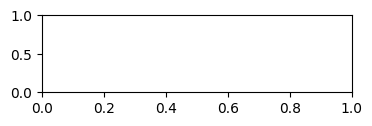

In [ ]:
df_indices = pd.DataFrame({
    'O_ADMDONG_CD': self_containment.index,
    'Self-Containment': self_containment.values,
    'Pull-Effect': pull_effect.reindex(self_containment.index).values # Reindex to align with self_containment
})

In [ ]:
# filtering out inf pull-effect and zero self-containment
df_indices = df_indices.replace([np.inf, -np.inf], np.nan)  # replace 'inf' with NaN
df_indices = df_indices[(df_indices['Self-Containment'] != 0) & (df_indices['Pull-Effect'].notna())]

In [ ]:
df_indices

,O_ADMDONG_CD,Self-Containment,Pull-Effect
0,11110515,0.177547,5.387227
1,11110530,0.100134,6.339530
2,11110540,0.061726,17.950530
3,11110550,0.188348,4.892523
4,11110560,0.192758,3.782845
...,...,...,...
1747,41830370,0.185012,3.572589
1748,41830380,0.206929,4.387708
1749,41830395,0.216244,3.114848
1750,41830400,0.463080,1.596806


In [ ]:
df_indices.to_excel('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices.xlsx', index=False)

#### adding English name of each dong

In [ ]:
# Load the indices file
indices_should_translate = pd.read_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices.xlsx", sheet_name = "all")

# Load the translation file
translation_df = pd.read_excel('/content/drive/MyDrive/FMC_Data/Eng_name_of_Korean_districts/Kor_to_Eng.xlsx', sheet_name = "hdong_eng_noje")
translation_df.head()

,code,Kor,Eng
0,1100000000,서울특별시,Seoul
1,1111000000,종로구,Jongno-gu
2,1111051500,청운효자동,Cheongunhyoja-dong
3,1111053000,사직동,Sajik-dong
4,1111054000,삼청동,Samcheong-dong


In [ ]:
indices_should_translate.head()

,ADMDONG_CD,Self-Containment,Pull-Effect,full_dong_name_in_Korean,sido,gu,dong,Unnamed: 7
0,11110515,0.177547,5.387227,서울특별시 종로구 청운효자동,서울특별시,종로구,청운효자동,NaN
1,11110530,0.100134,6.339530,서울특별시 종로구 사직동,서울특별시,종로구,사직동,NaN
2,11110540,0.061726,17.950530,서울특별시 종로구 삼청동,서울특별시,종로구,삼청동,NaN
3,11110550,0.188348,4.892523,서울특별시 종로구 부암동,서울특별시,종로구,부암동,NaN
4,11110560,0.192758,3.782845,서울특별시 종로구 평창동,서울특별시,종로구,평창동,NaN


In [ ]:
indices_should_translate = indices_should_translate.drop(columns=['Unnamed: 7'])

In [ ]:
# Create a dictionary from the translation DataFrame
translation_dict = translation_df.set_index('Kor')['Eng'].to_dict()

# Copy the Korean names to a new column and replace the words using the translation dictionary
indices_should_translate['full_dong_name_in_English'] = indices_should_translate['full_dong_name_in_Korean'].replace(translation_dict, regex=True)

In [ ]:
indices_should_translate.head()

,ADMDONG_CD,Self-Containment,Pull-Effect,full_dong_name_in_Korean,sido,gu,dong,full_dong_name_in_English
0,11110515,0.177547,5.387227,서울특별시 종로구 청운효자동,서울특별시,종로구,청운효자동,Seoul Jongno-gu Cheongunhyoja-dong
1,11110530,0.100134,6.339530,서울특별시 종로구 사직동,서울특별시,종로구,사직동,Seoul Jongno-gu Sajik-dong
2,11110540,0.061726,17.950530,서울특별시 종로구 삼청동,서울특별시,종로구,삼청동,Seoul Jongno-gu Samcheong-dong
3,11110550,0.188348,4.892523,서울특별시 종로구 부암동,서울특별시,종로구,부암동,Seoul Jongno-gu Buam-dong
4,11110560,0.192758,3.782845,서울특별시 종로구 평창동,서울특별시,종로구,평창동,Seoul Jongno-gu Pyeongchang-dong


In [ ]:
indices_should_translate.to_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_with_Engname.xlsx")